In [1]:
import warnings

import numpy as np
import pandas as pd
import xarray as xr

import arviz as az
import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as plt
%matplotlib inline

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
az.rcParams["stats.ic_pointwise"] = True

## Preprocessing
`18-19_table.txt` is a text file with data copied from Wikipedia straight away. The first step is to get the data in a clean format.

<div class="alert alert-info">

**Note:** I think this should not be added to the notebook, which is why the result is stored and reread below. I have added it for completeness

</div>

In [3]:
df_all = pd.read_csv("18-19_table.txt", sep="\t", comment="#")
team_names = df_all["Home \ Away "].str.strip().copy(deep=True).values
team_abbrs = df_all.columns.str.strip().copy(deep=True).values[1:]
df_all = df_all.melt(id_vars=["Home \ Away "])
df_all.columns = ["home_team", "away_team", "result"]
df_all = df_all.apply(lambda x: x.str.strip(), axis="index")
df_all = df_all.replace(
    {
        "away_team": {abbr: team for abbr, team in zip(team_abbrs, team_names)},
        "result": {"—": np.nan}
    }
).dropna(subset=["result"]).reset_index(drop=True)
df_aux = df_all.result.str.split("–", expand=True)
df_aux.columns = ["home_goals", "away_goals"]
df_final = pd.concat((df_all[["home_team", "away_team"]], df_aux), axis="columns")
df_final.to_csv("18-19_df.csv", index=False)

## Information criteria for hierarchical and multi-observation models
There are many situations where one model can be used for several prediction tasks at the same time. Hierarchical models or models with multiple observations are examples of such cases. With two observations for example, the same model can be used to predict only the first observation, only the second or both observations at the same time.

Before estimating the predictive accuracy, there are two important questions to answer: what is the predictive task we are interested in and, whether or not the exchangeability criteria is met. This section will show several alternative ways to define the predictive task using the same model.

## Base model
We are trying to model a league in which all teams play against each other twice. We indicate the number of goals scored by the home and the away team in the $g$-th game of the season ($n$ matches) as $y_{g,h}$ and $y_{g,a}$ respectively.
The model assumes the goals scored by a team follow a poisson distribution:

$$ y_{g,j} | \theta_{g,j} \sim \text{Poiss}(\theta_{g,j}) $$

where $j = {h, a}$ representing either home or away team. We will therefore start with a model containing two observation vectors: $\mathbf{y_h} = (y_{1,h}, y_{2,h}, \dots, y_{n,h})$ and $\mathbf{y_a} = (y_{1,a}, \dots, y_{n,a})$. In order to take into account each team scoring and defensive power and also the advantage of playing home, we will use different formulas for $\theta_{g,h}$ and for $\theta_{g,a}$:

$$
\begin{align}
\theta_{g,h} &= \beta_0 + home + atts_{home\_team} + defs_{away\_team}\\
\theta_{g,a} &= \beta_0 + atts_{away\_team} + defs_{home\_team}
\end{align}
$$

The expectation on the home team goals depends on an intercept, $\beta_0$, $home$ to quantify the home advantage, on the attacking power of the home teal and on the defensive power of the away team. Similarly, the expectation on the away team goals also depends on the intercept but not on the home advantage, and now, consequently, we use the attacking power of the away team and the defensive power of the home team.

<div class="alert alert-info">

**Note:** Expectation? Expected value? and what proposition is the correct one?

</div>

Summing up and including the priors, our base model is the follwing one:

$$
\begin{align}
\beta_0 &\sim \text{Normal}(0,5) \\
home &\sim \text{Normal}(0,5) \\
sd_{att} &\sim \text{HalfStudentT}(3,2.5) \\
sd_{def} &\sim \text{HalfStudentT}(3,2.5) \\
atts_* &\sim \text{Normal}(0,sd_{att}) \\
defs_* &\sim \text{Normal}(0,sd_{def}) \\
\mathbf{y}_h &\sim \text{Poiss}(\theta_h) \\
\mathbf{y}_a &\sim \text{Poiss}(\theta_a) 
\end{align}
$$

where $\theta_j$ has been defined above, $atts = atts_* - \text{mean}(atts_*)$ and $defs$ is defined like $atts$.

### Data

In [4]:
df = pd.read_csv("18-19_df.csv")
home_team_idxs, team_names = pd.factorize(df.home_team, sort=True)
away_team_idxs, _ = pd.factorize(df.away_team, sort=True)
num_teams = len(team_names)
df

,home_team,away_team,home_goals,away_goals
0,Bournemouth,Arsenal,1,2
1,Brighton & Hove Albion,Arsenal,1,1
2,Burnley,Arsenal,1,3
3,Cardiff City,Arsenal,2,3
4,Chelsea,Arsenal,3,2
...,...,...,...,...
375,Newcastle United,Wolverhampton Wanderers,1,2
376,Southampton,Wolverhampton Wanderers,3,1
377,Tottenham Hotspur,Wolverhampton Wanderers,1,3
378,Watford,Wolverhampton Wanderers,1,2


### Model implementation

In [5]:
with pm.Model() as m_base:
    # constant data
    home_team = pm.intX(pm.Data("home_team", home_team_idxs))
    away_team = pm.intX(pm.Data("away_team", away_team_idxs))
    
    # global model parameters
    home = pm.Normal('home', mu=0, sigma=5)
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Normal('intercept', mu=0, sigma=5)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, shape=num_teams)

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data
    home_goals = pm.Poisson('home_goals', mu=home_theta, observed=df.home_goals)
    away_goals = pm.Poisson('away_goals', mu=away_theta, observed=df.away_goals)

### Inference

In [6]:
dims = {
    "home_goals": ["match"],
    "away_goals": ["match"],
    "home_team": ["match"],
    "away_team": ["match"],
    "atts": ["team"],
    "atts_star": ["team"],
    "defs": ["team"],
    "defs_star": ["team"],
}
coords = {"team": team_names}
with m_base:
    trace = pm.sample(random_seed=1375)
    idata_base = az.from_pymc3(trace, coords=coords, dims=dims)

# define helpers to make code less verbose
log_lik = idata_base.log_likelihood
const = idata_base.constant_data

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1656.06draws/s]


In [7]:
idata_base

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

### Information criterion calculation
Due to the presence of the two observations in our model, we cannot call `az.loo` or `az.waic` straight away because the predictive task to evaluate is ambiguous. The calculation of information criteria requires pointwise likelihood values, $p(y_i|\theta)$ with $y_i$ indicating observation $i$-th and $\theta$ representing all the parameters in the model. We need to define $y_i$, what does _one observation_ represent in our model.

As we were introducing above, this model alone can tackle several predictive tasks. These predictive tasks can be identified by the definition of _one observation_ which at the same time defines how are pointwise likelihood values to be calculated. Here are some examples:
* We could be a group of students supporting different teams with budget to travel only to one away match of our respective teams. We may want to travel to the match were our team will score the most goals (while being the away team and also independently of the winner of the match). We will therefore assess the predictive accuracy of our model using only $\mathbf{y}_a$.
* We could also be football fans without any clear allegiance who love an intense match between two teams of similar strength. Based on previous experience, we may consider matches that end up 3-3 or 4-4 the ones that better fit our football taste. Now we need to assess the predictive accuracy using the result of the whole match.
* Even another alternative would be wanting to be present at the match where a single team scores the most goals. In this situation, we would have to put both home and away goals in the same _bag_ and assess the predictive accuracy on the ability to predict values from this _bag_, we may call the observations in this hypothetical bag "number of goals scored per match and per team".

There are even more examples of predictive tasks where this particular model can be of use. However, it is important to keep in mind that this model predicts number of scored goals, its results can be used to estimate probabilities of victory and other derived quantities, but calculating the likelihood of these derived quantities may not be straighforward.

Even though we know that the predictive task is ambiguous, we will start trying to calculate `az.loo` with `idata_base` and then work on the examples above and a couple more to show how would this kind of tasks be performed with ArviZ.

In [8]:
az.loo(idata_base)

TypeError: Found several log likelihood arrays ['home_goals', 'away_goals'], var_name cannot be None

<div class="alert alert-info">

**Note:** I guess we can change the error message after the notebook is finished

</div>

As expected, ArviZ has no way of knowing what predictive task we have in mind so it raises an error. 

#### Predicting the goals scored by the home team
In this particular case, we can write the pointwise log likelihood in the following way:

$$ p(y_i|\theta) = p(y_{i,h}|\theta_{i,h}) = \text{Poiss}(y_{i,h}; \theta_{i,h}) $$

with $i$ being the match indicator ($g$) in this case. These are precisely the values stored in the `home_goals` of the `log_likelihood` group of `idata_base`. We can tell ArviZ to use these values using the argument `var_name`.

In [9]:
az.loo(idata_base, var_name="home_goals")

Computed from 2000 by 380 log-likelihood matrix

         Estimate       SE
elpd_loo  -567.64    11.19
p_loo       14.99        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      380  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

##### Alternative implementation 
Here there is an example of an alternative implementation of the same model, but targeted to this specific predictive task. Notice how we do not throw away the info provided by `away_goals`, we simply modify how it is taken into account to make it clear we do not care about predicting these values.

In [10]:
with pm.Model() as m_home:
    # same code as m_base
    home_team = pm.intX(pm.Data("home_team", pd.factorize(df.home_team, sort=True)[0]))
    away_team = pm.intX(pm.Data("away_team", pd.factorize(df.away_team, sort=True)[0]))
    home = pm.Normal('home', mu=0, sigma=5)
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Normal('intercept', mu=0, sigma=5)
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, shape=num_teams)
    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])
    
    home_goals = pm.Poisson('home_goals', mu=home_theta, observed=df.home_goals)
    # difference
    pm.Potential("away_goals", pm.Poisson.dist(mu=away_theta).logp(df.away_goals.values))

In [11]:
dims.pop("away_goals")
with m_home:
    trace = pm.sample(random_seed=1374) # use different seed, same one gives exactly the same result
    idata_home = az.from_pymc3(trace, coords=coords, dims=dims)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1560.64draws/s]


In [12]:
az.loo(idata_home)

Computed from 2000 by 380 log-likelihood matrix

         Estimate       SE
elpd_loo  -567.69    11.17
p_loo       14.99        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      380  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

#### Predicting the outcome of a match
Another option is being interested in the outcome of the matches. In our current model, the outcome of a match is not who wins or the aggregate of scored goals by both teams, the outcome is the goals scored by the home team _and_ by the away team, both quantities at the same time. The _one observation_ in this situation is therefore a vector with two components: $y_i = (y_{i,h}, y_{i,a})$. Like above, we also have $n$ observations. The pointwise likelihood is therefore a product:

$$ 
p(y_i|\theta) = p(y_{i,h}|\theta_{i,h})p(y_{i,a}|\theta_{i,a}) = 
\text{Poiss}(y_{i,h}; \theta_{i,h})\text{Poiss}(y_{i,a}; \theta_{i,a})
$$

with $i$ still being equal to the match indicator $g$. Therefore, we have $n$ observations like in the previous example, but each observation has two components. 

We can calculate the product as a sum of logarithms and store the result in a new variable inside the `log_likelihood` group.

In [13]:
log_lik["matches"] = log_lik.home_goals + log_lik.away_goals
az.loo(idata_base, var_name="matches")

Computed from 2000 by 380 log-likelihood matrix

         Estimate       SE
elpd_loo -1100.95    16.87
p_loo       29.11        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      380  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

##### Alternative implementation

In [14]:
with pm.Model() as m_match:
    # constant data
    home_team = pm.intX(pm.Data("home_team", pd.factorize(df.home_team, sort=True)[0]))
    away_team = pm.intX(pm.Data("away_team", pd.factorize(df.away_team, sort=True)[0]))
    
    # global model parameters
    home = pm.Normal('home', mu=0, sigma=5)
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Normal('intercept', mu=0, sigma=5)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, shape=num_teams)

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])

    # alternative likelihood of observed data
    def double_poisson(home_goals, away_goals):
        return (
            pm.Poisson.dist(mu=home_theta).logp(home_goals) + 
            pm.Poisson.dist(mu=away_theta).logp(away_goals)
        )
    
    matches = pm.DensityDist('matches', double_poisson, observed={
        'home_goals': df.home_goals, 'away_goals': df.away_goals
    })

In [15]:
dims = {
    "matches": ["match"],
    "home_goals": ["match"],
    "away_goals": ["match"],
    "home_team": ["match"],
    "away_team": ["match"],
    "atts": ["team"],
    "atts_star": ["team"],
    "defs": ["team"],
    "defs_star": ["team"],
}
coords = {"team": pd.factorize(df.home_team, sort=True)[1]}
with m_match:
    trace = pm.sample(random_seed=1375, tune=1500)
    idata_match = az.from_pymc3(trace, coords=coords, dims=dims)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1801.21draws/s]


In [16]:
az.loo(idata_match)

Computed from 2000 by 380 log-likelihood matrix

         Estimate       SE
elpd_loo -1101.46    16.86
p_loo       29.41        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      380  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

#### Predicting the goals scored per match and per team
Another example described above is being interested in the scored goals per match and per team. In this situation, our observations are a scalar once again. The expression of the likelihood is basically the same as the one in the first example (both cases are scalars), but the difference is in the index, but that does not make it less significant:

$$ 
p(y_i|\theta) = p(y_{i}|\theta_{i}) = 
\text{Poiss}(y_{i}; \theta_{i})
$$

with $i$ not being equal to the match indicator $g$ anymore. Now, we will consider $i$ as an index iterating over the values in 

$$\big\{(1,h), (2,h), \dots, (n-1,h), (n,h), (1,a), (2,a) \dots (n-1,a), (n,a)\big\}$$

Therefore, unlike in previous cases, we have $2n$ observations. 

We can obtain the pointwise log likelihood corresponding to this case by concatenating the pointwise log likelihoods of `home_goals` and `away_goals`. Then, like in the previous case, store the result in a new variable inside the `log_likelihood` group.

In [17]:
log_lik["goals"] = xr.concat((log_lik.home_goals, log_lik.away_goals), "match").rename({"match": "goal"})
az.loo(idata_base, var_name="goals")

Computed from 2000 by 760 log-likelihood matrix

         Estimate       SE
elpd_loo -1100.88    17.70
p_loo       28.99        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      760  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

##### Alternative implementation

<div class="alert alert-info">

**Note:** There is a simpler implementation which is basically identical to the base one but assuming a single observation which is therefore a matrix with $n$ rows and 2 columns. However, I think this makes a better job to highlight the differences between the different cases.

</div>

In [18]:
df_home = df[["home_team", "away_team", "home_goals"]].rename(columns={"home_goals": "goals"})
df_home["visitor"] = 0
df_away = df[["home_team", "away_team", "away_goals"]].rename(columns={"away_goals": "goals"})
df_away["visitor"] = 1
df_goals = pd.concat((df_home, df_away), axis="index")

with pm.Model() as m_goals:
    # constant data
    home_team = pm.intX(pm.Data("home_team", pd.factorize(df_goals.home_team, sort=True)[0]))
    away_team = pm.intX(pm.Data("away_team", pd.factorize(df_goals.away_team, sort=True)[0]))
    is_visitor = pm.intX(pm.Data("is_visitor", df_goals.visitor))
    
    # global model parameters
    home = pm.Normal('home', mu=0, sigma=5)
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Normal('intercept', mu=0, sigma=5)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, shape=num_teams)

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_aux = tt.stack([home, 0])
    pars_aux = tt.stack([defs, atts])
    theta = tt.exp(
        intercept + home_aux[is_visitor] + pars_aux[(is_visitor, away_team)] + pars_aux[(1-is_visitor, home_team)]
    )

    # alternative likelihood of observed data
    goals = pm.Poisson('goals', mu=theta, observed=df_goals.goals.values)

In [19]:
dims = {
    "is_visitor": ["idx"],
    "goals": ["idx"],
    "home_team": ["idx"],
    "away_team": ["idx"],
    "atts": ["team"],
    "atts_star": ["team"],
    "defs": ["team"],
    "defs_star": ["team"],
}
coords = {"team": pd.factorize(df_goals.home_team, sort=True)[1]}
with m_goals:
    trace = pm.sample(random_seed=1375, tune=1500)
    idata_goals = az.from_pymc3(trace, coords=coords, dims=dims)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:07<00:00, 1045.31draws/s]


In [20]:
az.loo(idata_goals)

Computed from 2000 by 760 log-likelihood matrix

         Estimate       SE
elpd_loo -1101.07    17.69
p_loo       29.18        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      760  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

#### Predicting team level performance

<div class="alert alert-warning">

**TODO:** 

</div>

In [21]:
home_goals_team = log_lik.home_goals.groupby(const.home_team).sum().rename({"home_team": "team"})
away_goals_team = log_lik.away_goals.groupby(const.away_team).sum().rename({"away_team": "team"})
log_lik["teams"] = home_goals_team + away_goals_team
az.loo(idata_base, var_name="teams")

/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/arviz/stats/stats.py:671: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 2000 by 20 log-likelihood matrix

         Estimate       SE
elpd_loo -1103.64    30.03
p_loo       27.57        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    5.0%
 (0.5, 0.7]   (ok)          4   20.0%
   (0.7, 1]   (bad)        12   60.0%
   (1, Inf)   (very bad)    3   15.0%

## Sanity check
Are all the alternative implementations really equivalent? Let's see

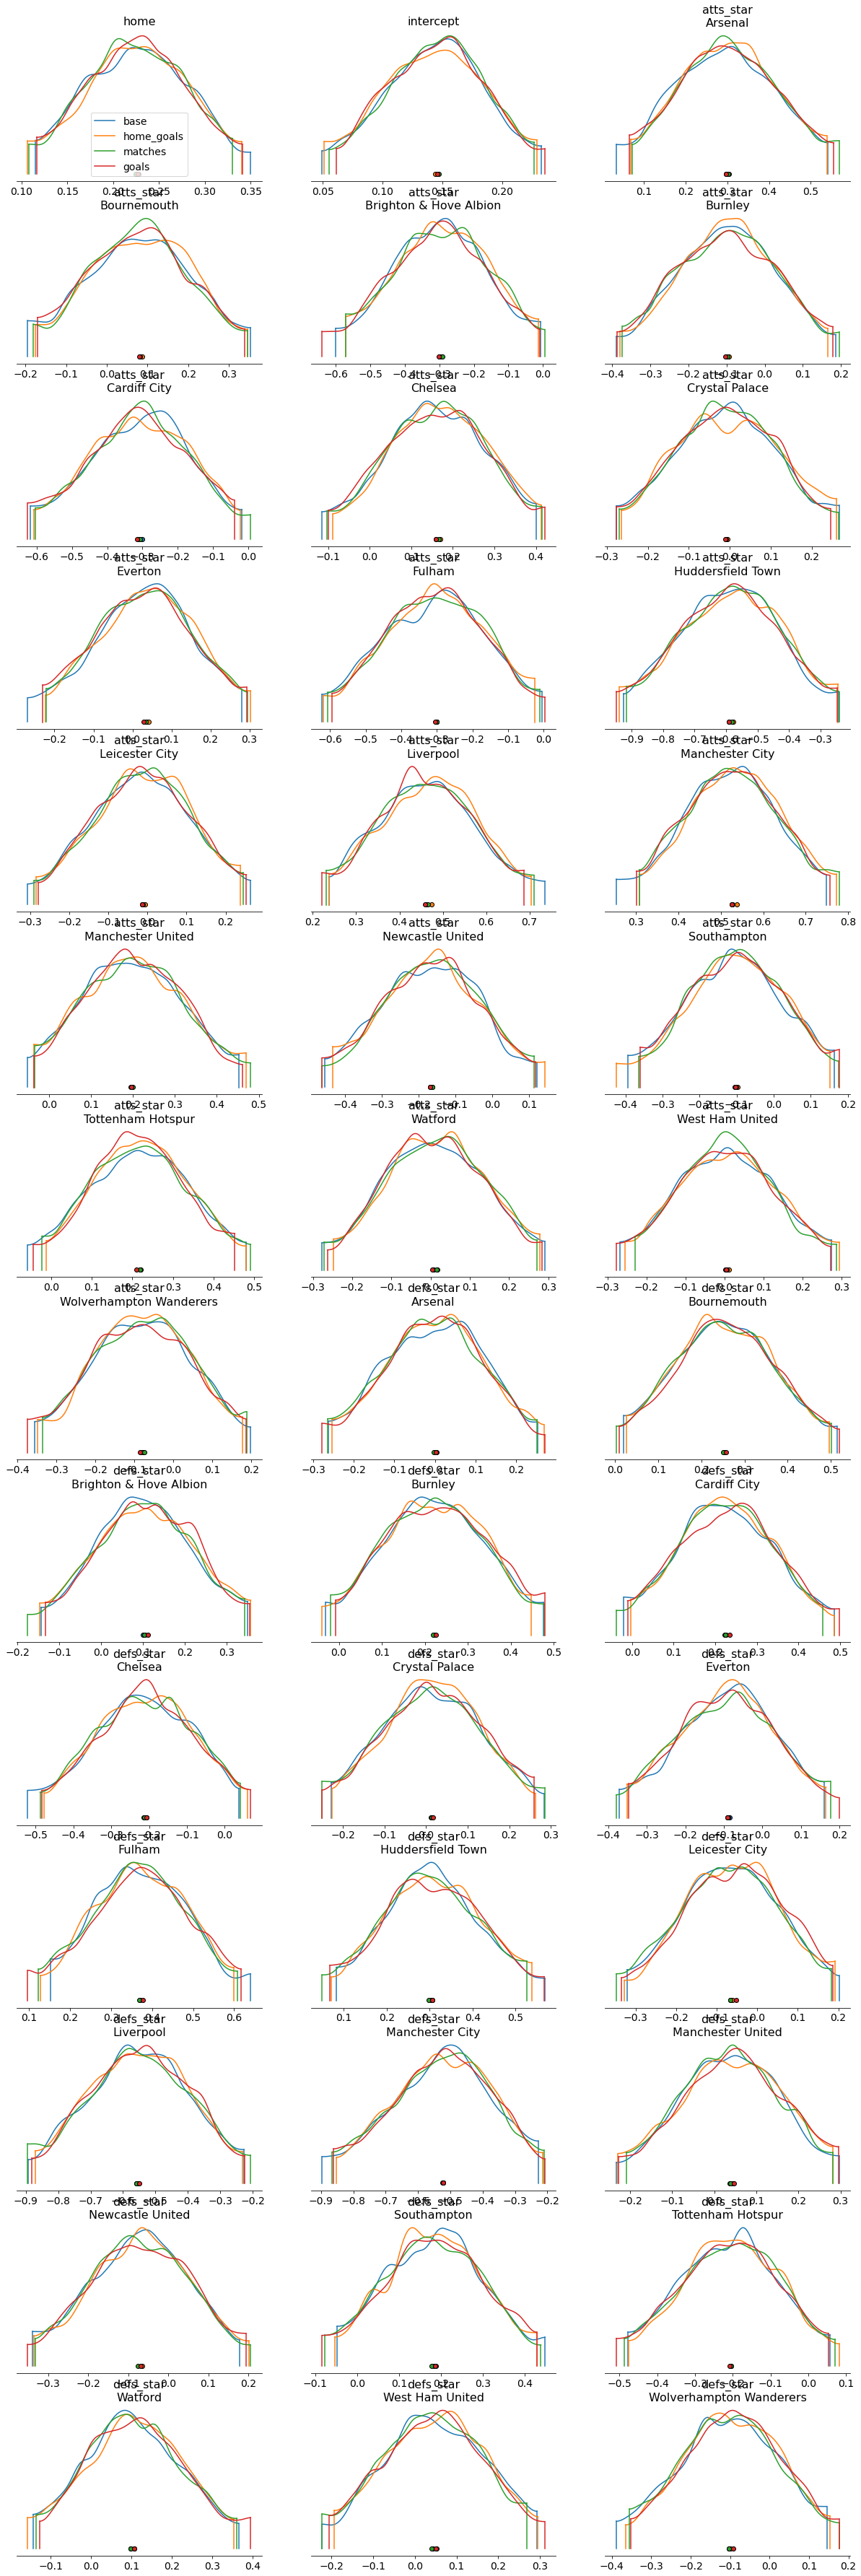

In [22]:
with az.rc_context({"plot.max_subplots": 50}):
    az.plot_density(
        (idata_base, idata_home, idata_match, idata_goals), 
        data_labels=("base", "home_goals", "matches", "goals"),
        var_names=["home", "intercept", "atts_star", "defs_star"]
        
    );

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w

xarray 0.15.1
pymc3  3.8
arviz  0.8.3
pandas 1.0.4
numpy  1.18.5
last updated: Thu Jun 11 2020 

CPython 3.6.9
IPython 7.15.0
watermark 2.0.2
